### Importations des librairies

In [1]:
import matplotlib.pyplot as plt
from pysheds.grid import Grid
import pandas as pd
import numpy as np
import pickle
import seaborn as sns
import plotly.graph_objects as go
import cv2
from scipy import stats
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import warnings
warnings.filterwarnings("ignore")

### Conversion de la zone de travail en raster

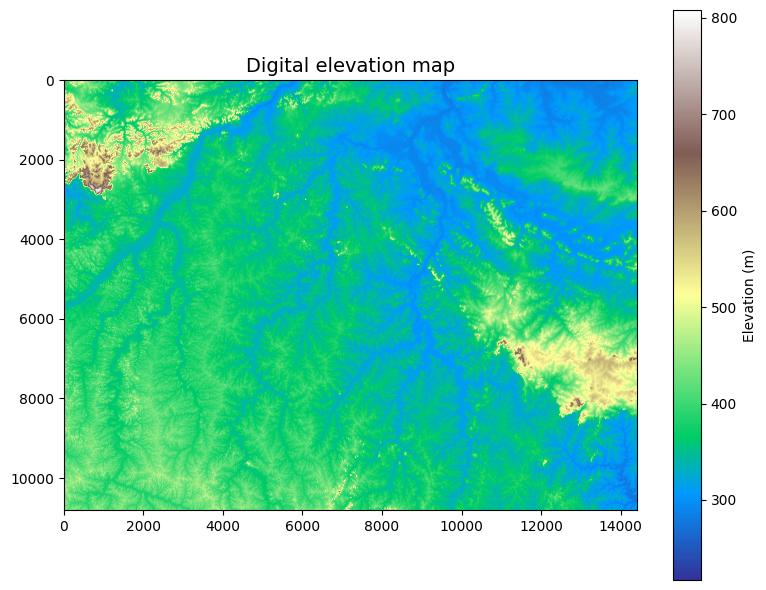

In [3]:
# Importation carte
path = "merged_map.tif" #Chemin d'accès vers le dem au format .tif. On télécharge plusieurs dem au format .tif qui couvrent toute
                        #la région de travail sur USGS puis on merge ces dem avec ARCGIS ou QGIS pour obtenir un grand dem qui 
                        #couvre toute la région de d'étude.

grid = Grid.from_raster(path, data_name="dem")
dem = grid.read_raster(path)

fig, ax = plt.subplots(figsize=(8,6))
fig.patch.set_alpha(0)

plt.imshow(grid.view(dem), cmap='terrain', zorder=1)
plt.colorbar(label='Elevation (m)')
plt.title('Digital elevation map', size=14)
plt.tight_layout()

In [4]:
# Création des cartes constantes -> carte des denivelés filled, des directions, des accumulations et des gradients
# WARNING : Met plusieurs minutes à tourner (6min sur mon ordinateur)
pit_filled_dem = grid.fill_pits(dem)
flooded_dem = grid.fill_depressions(pit_filled_dem)
inflated_dem = grid.resolve_flats(flooded_dem) #dem
fdir = grid.flowdir(inflated_dem) #carte des directions. Numpy array de même taille que le dem. Pour chaque case donne la direction
                                  #vers laquelle irait une goutte d'eau à partir de ce point. Encodage ordinal (les directions sont
                                  #représentées par des puissances de 2)
acc = grid.accumulation(fdir) #carte des accumulations. Numpy array de même taille que le dem. Pour chaque case donne la valeur
                              #de l'accumulation en ce point

kernel_size = (5, 5)
sigma = 1.0
inflated_dem = cv2.GaussianBlur(inflated_dem, kernel_size, sigma) #Pour lisser le dem

grads = np.gradient(inflated_dem)
grad_x = grads[0]
grad_y = grads[1]
grad = np.sqrt(grad_x**2 + grad_y**2) #Carte des pentes. Numpy array de même taille que le dem. Pour chaque case donne la pente en ce point

In [5]:
#Optionnel: pour sauvegarder les cartes calculées pour ne pas refaire le calcul à chaque fois
np.save("inflated_dem.npy", inflated_dem)
np.save("fdir.npy", fdir)
np.save("acc.npy", acc)
np.save("grad.npy", grad)

with open('grid_affine.pkl', 'wb') as f:
    pickle.dump(grid.affine, f)

### Etude du terrain

In [6]:
#Si on a sauvegardé les cartes calculées précédemment, on peut les recharger à partir de cette cellule, donc plus besoin
#des cellules 2, 3 et 4.
inflated_dem = np.load('inflated_dem.npy')
fdir = np.load('fdir.npy')
acc = np.load('acc.npy')

with open('grid_affine.pkl', 'rb') as f:
    grid_affine = pickle.load(f)

In [7]:
#On importe un des excels contenant les profondeurs des nappes
df = pd.read_excel("Mali.xlsx")
df.head()

,CODE_OUVRA,LON,LAT,DATE,NS
0,02P002033,-7.927145,12.315893,1920-01-01,12.52
1,02P000014,-7.924242,12.262468,1920-01-01,18.55
2,03P000520,-7.680555,11.347780,1947-01-01,8.40
3,03P000705,-7.600861,11.668355,1952-01-01,6.00
4,02P002039,-7.926866,12.315960,1952-01-01,12.06


In [49]:
#Fonctions utiles pour calculer les features

def convert_coord_to_indices(lon, lat):
    #Transforme des coordonnées longitude, latitude en coordonnées dans le raster (colonne, ligne)
    col = round((lon - grid_affine[2]) / grid_affine[0])
    row = round((lat - grid_affine[5]) / grid_affine[4])
    return col, row

def find_paths(map_direction, start_point):
    #Prend la carte des directions "fdir" et un point de départ (ligne, colonne). La fonction retournera
    #alors la liste des points qui se déversent en ce point de départ. Souvent, le point de départ 
    #représentera la sortie d'un bassin versant. La fonction retournera alors les coordonnées de tous
    #les points de ce bassin versant.
    #Cette fonction permet donc de mapper tout un bassin versant à partir d'un point de sortie de ce bassin versant.
    dir_map = {64: (-1, 0), 
                    128: (-1, 1), 
                    1: (0, 1), 
                    2: (1, 1), 
                    4: (1, 0), 
                    8: (1, -1), 
                    16: (0, -1), 
                    32: (-1, -1)}
    def is_valid_move(x, y):
        return 0 <= x < map_direction.shape[0] and 0 <= y < map_direction.shape[1] and not visited[x, y]

    def dfs(x, y, path):
        visited[x, y] = True
        for dx, dy in [(1, 0), (-1, 0), (0, 1), (0, -1), (-1, 1), (1, -1), (1, 1), (-1, -1)]:
            new_x, new_y = x + dx, y + dy
            if is_valid_move(new_x, new_y) and dir_map.get(map_direction[new_x, new_y], (0, 0)) == (-dx, -dy):
                dfs(new_x, new_y, path + [(new_x, new_y)])
        paths.append(path)
        visited[x, y] = False
        return

    paths = []
    visited = np.zeros(map_direction.shape, dtype=bool)
    dfs(*start_point, [start_point])
    return paths

def contour_custom(mask):
    #Prend un mask (un tableau numpy de 0 et de 1 avec les 1 qui forment un ensemble plein (connexe par arc), comme un bassin versant, 
    #et retourne le contour de cet ensemble (dans le cas d'un bassin versant, cela retournera les crêtes)).
    new_mask = np.zeros_like(mask)
    for i, j in zip(np.where(mask==1)[0], np.where(mask==1)[1]):
        if mask[i, j]==1 and (mask[i+1, j]!=1 or mask[i-1, j]!=1 or mask[i, j+1]!=1 or mask[i, j-1]!=1):
            new_mask[i, j]=1
    return new_mask

def move_one_step(col, row, fdir):
    #Trouve la case où irait une goutte d'eau à partir des coordonnées (ligne, colonne) et de la carte des directions "fdir".
    direction = fdir[row, col]

    delta_dir = {
        64: (-1, 0),
        128: (-1, 1),
        1: (0, 1),
        2: (1, 1),
        4: (1, 0),
        8: (1, -1),
        16: (0, -1),
        32: (-1, -1),
    }.get(direction, (0, 0))
    return col + delta_dir[1], row + delta_dir[0]

def dist_one_step(row, col, fdir):
    #Trouve la distance parcourue par une goutte d'eau à partir des coordonnées (ligne, colonne) pour aller à la case suivante.
    #Cette distance vaut soit 1 (parcours unilatéral) soit racine de 2 (parcours diagonal).
    direction = fdir[row, col]

    delta_dist = {
        64: 1,
        128: np.sqrt(2),
        1: 1,
        2: np.sqrt(2),
        4: 1,
        8: np.sqrt(2),
        16: 1,
        32: np.sqrt(2),
    }

    if direction in delta_dist:
        return delta_dist[direction]
    else:
        print("direction non reconnue")
        return ValueError

def find_stream(row, col, acc, threshold, fdir):
    #Descend la pente à partir d'un point (ligne, colonne) et renvoie tout le chemin jusqu'à croiser un cours d'eau.
    new_col, new_row = col, row
    consecutive_count = 0
    res_x = []
    res_y = []
    while consecutive_count < 1:
        if acc[new_row, new_col] >= threshold:
            consecutive_count += 1
        else:
            consecutive_count = 0
        res_x.append(new_col)
        res_y.append(new_row)
        new_col, new_row = move_one_step(col=new_col, row=new_row, fdir=fdir)
    return res_x, res_y

def trace_stream(row, col, fdir, distance_meters, cellsize=30):
    distance_covered = 0
    
    while distance_covered < distance_meters:
        col, row = move_one_step(row=row, col=col, fdir=fdir)
        delta_dist = dist_one_step(row=row, col=col, fdir=fdir)
        distance_covered += delta_dist * cellsize

    return row, col

def bresenham_line(x0, y0, x1, y1):
    #Trace une ligne directe entre deux coordonnées spécifiés
    points = []
    dx = abs(x1 - x0)
    dy = abs(y1 - y0)
    sx = 1 if x0 < x1 else -1
    sy = 1 if y0 < y1 else -1
    err = dx - dy
    
    while True:
        points.append((x0, y0))
        if x0 == x1 and y0 == y1:
            break
        e2 = err * 2
        if e2 > -dy:
            err -= dy
            x0 += sx
        if e2 < dx:
            err += dx
            y0 += sy
            
    return points

def good_side(path, acc, threshold):
    #Vérifie si le chemin donné (path) passe par un cours d'eau ou non
    for col, row in path:
        if acc[row, col] > threshold:
            return False
    return True

In [74]:
def visualize(index: int, threshold: int=1500, distance_meters: int = 1200, size: int = 200):
    #Prend un index de notre dataframe df et affiche en 3d la région (dem) aux alentours du point représenté par cette ligne de df, avec le
    #contour du bassin versant calculé en noir, le point lui-même en rouge, les cours d'eau calculés à partir d'un seuillage de l'accumulation
    #(à 1500 par défaut) en bleu, et les points du cours d'eau et de la crête du bassin versant les plus proches de ce point en jaune.
    #Il y a au fur-et-à-mesure des étapes les commentaires explicatifs associés.

    #1) On trouve les coordonnées (colonne, ligne) dans le dem du point représenté par cet index dans df.
    point_col, point_row = convert_coord_to_indices(lon=df.loc[index, "LON"], 
                                        lat=df.loc[index, "LAT"])

    #2) On trouve le chemin qui mène au cours d'eau à partir du point, en suivant le sens de la pente.
    path_x, path_y = find_stream(col=point_col, 
                                 row=point_row, 
                                 acc=acc, 
                                 threshold=threshold, 
                                 fdir=fdir)

    #3) On part du point le plus proche du cours d'eau (dernier point du chemin qui mène au cours d'eau) et on continue
    #quelques mètres plus loin le long du cours d'eau (le nombre de mètres est fixé par le paramètre "distance_meters")
    #On fixe la sortie de notre bassin versant (outlet) au point trouvé après avoir parcouru ces quelques mètres le long du 
    #cours d'eau.
    row, col = trace_stream(row=path_y[-1], 
                          col=path_x[-1], 
                          fdir=fdir,
                          distance_meters=distance_meters)
    outlet = (row, col)
    
    #4) On restreint la zone d'étude à un carré autour de l'outlet
    row_min = outlet[0] - size
    row_max = outlet[0] + size
    col_min = outlet[1] - size
    col_max = outlet[1] + size

    #5) On utilise la fonction find_paths pour trouver tous les points du dem qui se déversent en l'outlet trouvé (i.e. 
    #tous les points qui emmène une goutte d'eau vers ce point en suivant la pente). Ces points forment le
    #bassin versant de notre point. On utilise également la fonction custom_contour pour obtenir le contour du bassin versant
    #(i.e. les crêtes).
    paths = find_paths(fdir, outlet)
    flattened_list = {item for sublist in paths for item in sublist}
    catch = np.zeros_like(inflated_dem)
    for element in flattened_list:
        catch[element]=1
    contour_catch = np.where(contour_custom(catch)==1)
    contour_catch_x = contour_catch[1]
    contour_catch_y = contour_catch[0]
    contour_catch_z = [inflated_dem[row, col] for row, col in zip(contour_catch_y, contour_catch_x)]

    #6) Pour chaque point de crête du bassin versant (i.e. pour tous les points du contour du bassin versant), on trace
    #le chemin pour aller de ce point de crête jusqu'au cours d'eau en suivant la pente. On trouve le "point de crête le plus proche"
    #de notre point d'étude en le fixant comme étant le point de crête dont le chemin qui mène au cours d'eau passe au plus près de notre
    #point d'étude. On appelle notre "point de crête le plus proche" "res_top"
    res_top = None
    inter_dist = np.inf
    for catch_row, catch_col in zip(contour_catch_y, contour_catch_x):
        res_x, res_y = find_stream(row=catch_row, col=catch_col, acc=acc, threshold=threshold, fdir=fdir)
        path_to_stream = [(row, col) for col, row in zip(res_x, res_y)]
        distance_minimale = min([np.sqrt((row - point_row)**2 + (col - point_col)**2) for row, col in path_to_stream])
        if distance_minimale < inter_dist:
            inter_dist = distance_minimale
            res_top = (catch_row, catch_col)
    
    #7) On appelle notre "point de cours d'eau le plus proche" "res_stream".
    res_stream = (path_y[-1], path_x[-1])

    #8) Les lignes suivantes ne servent que pour la visualisation 3d (inutile pour le modèle de machine learning)
    col_coords = [point_col]
    row_coords = [point_row]
    z_coords = [inflated_dem[row, col] for col, row in zip(col_coords, row_coords)]

    region_cols, region_rows = np.meshgrid(
        np.arange(col_min, col_max),
        np.arange(row_min, row_max)
    )
    region_points = np.vstack([region_cols.ravel(), region_rows.ravel()]).T

    threshold_points = [
        (col, row) for col, row in region_points
        if acc[row, col] > threshold
    ]
    threshold_col_coords = [col for col, row in threshold_points]
    threshold_row_coords = [row for col, row in threshold_points]
    threshold_z_coords = [inflated_dem[row, col] for col, row in threshold_points]

    surface_x = np.linspace(col_min, col_max, col_max - col_min + 1)
    surface_y = np.linspace(row_min, row_max, row_max - row_min + 1)
    surface_z = inflated_dem[row_min: row_max, col_min: col_max]

    fig = go.Figure(data=[
        go.Surface(x=surface_x, y=surface_y, z=surface_z, colorscale='Viridis', opacity=1),
        go.Scatter3d(x=threshold_col_coords, y=threshold_row_coords, z=threshold_z_coords, mode='markers', marker=dict(color='blue', size=5), name='Accumulation > Threshold'),
        go.Scatter3d(x=contour_catch_x, y=contour_catch_y, z=contour_catch_z, mode='markers', marker=dict(color='black', size=5), name='Contour catchment'),
        go.Scatter3d(x=col_coords, y=row_coords, z=z_coords, mode='markers', marker=dict(color='red', size=8)),
        go.Scatter3d(x=[res_top[1]], y=[res_top[0]], z=[inflated_dem[res_top]], mode='markers', marker=dict(color='yellow', size=8)),
        go.Scatter3d(x=[res_stream[1]], y=[res_stream[0]], z=[inflated_dem[res_stream]], mode='markers', marker=dict(color='yellow', size=8)),
    ])

    fig.update_layout(scene=dict(
                        xaxis_title='Longitude',
                        yaxis_title='Latitude',
                        zaxis_title='Z (Planche)'
                    ),
                    autosize=False,
                    scene_aspectmode='data')

    fig.show()

In [ ]:
index = 2
visualize(index=index) #Graphe 3d interactif (on peut se déplacer à l'intérieur, zoomer, etc.)

In [78]:
dataset = df.copy() #dataframe dans lequel on va mettre les features calculées
#On prépare ci-dessous les colonnes "top" et "stream" dans lequelles on va mettre pour chaque ligne de df les coordonnées dans
#le dem (ligne, colonne) du point de crête et du point de cours d'eau les plus proches.
dataset["top"] = pd.Series(index=dataset.index, dtype='object')
dataset["stream"] = pd.Series(index=dataset.index, dtype='object')

In [88]:
def pipeline(index: int, threshold: int=1500, distance_meters: int = 1200, size: int = 400):
    #On applique exactement la même méthode que la fonction visualize mais au lieu d'afficher les résultats dans un graphe en 3d, on va
    #pour chaque ligne de df stocker les coordonnées (ligne, colonne) du point de crête le plus proche et du point de cours d'eau le plus 
    #proche dans le dataframe "dataset"

    #1) On trouve les coordonnées (colonne, ligne) dans le dem du point représenté par cet index dans df.
    point_col, point_row = convert_coord_to_indices(lon=df.loc[index, "LON"], 
                                        lat=df.loc[index, "LAT"])

    #2) On trouve le chemin qui mène au cours d'eau à partir du point, en suivant le sens de la pente.
    path_x, path_y = find_stream(col=point_col, 
                                 row=point_row, 
                                 acc=acc, 
                                 threshold=threshold, 
                                 fdir=fdir)
    
    #3) On part du point le plus proche du cours d'eau (dernier point du chemin qui mène au cours d'eau) et on continue
    #quelques mètres plus loin le long du cours d'eau (le nombre de mètres est fixé par le paramètre "distance_meters")
    #On fixe la sortie de notre bassin versant (outlet) au point trouvé après avoir parcouru ces quelques mètres le long du 
    #cours d'eau.
    row, col = trace_stream(row=path_y[-1], 
                          col=path_x[-1], 
                          fdir=fdir,
                          distance_meters=distance_meters)
    outlet = (row, col)

    #4) On utilise la fonction find_paths pour trouver tous les points du dem qui se déversent en l'outlet trouvé (i.e. 
    #tous les points qui emmène une goutte d'eau vers ce point en suivant la pente). Ces points forment le
    #bassin versant de notre point. On utilise également la fonction custom_contour pour obtenir le contour du bassin versant
    #(i.e. les crêtes).
    #IMPORTANT : ON RESTREINT LA ZONE D'ETUDE A UN VOISINAGE DE NOTRE POINT D'ETUDE POUR LIMITER L'IMPACT MEMOIRE DES CALCULS.
    #SI DURANT L'EXECUTION DE CETTE FONCTION ON OBTIENT UN "OUT OF RANGE" CELA SIGNIFIE QU'ON A TROP RESTREINT ET DONC IL FAUDRA
    #AUGMENTER LA VALEUR DU PARAMETRE SIZE.
    paths = find_paths(fdir, outlet)
    flattened_list = {item for sublist in paths for item in sublist}
    catch = np.zeros_like(inflated_dem[point_row - size: point_row + size, point_col - size: point_col + size])
    for element in flattened_list:
        catch[element[0] - (point_row - size), element[1] - (point_col - size)]=1
    contour_catch = np.where(contour_custom(catch)==1)
    contour_catch_x = contour_catch[1] + point_col - size
    contour_catch_y = contour_catch[0] + point_row - size

    #5) Pour chaque point de crête du bassin versant (i.e. pour tous les points du contour du bassin versant), on trace
    #le chemin pour aller de ce point de crête jusqu'au cours d'eau en suivant la pente. On trouve le "point de crête le plus proche"
    #de notre point d'étude en le fixant comme étant le point de crête dont le chemin qui mène au cours d'eau passe au plus près de notre
    #point d'étude. On appelle notre "point de crête le plus proche" "res_top"
    res_top = None
    inter_dist = np.inf
    for catch_row, catch_col in zip(contour_catch_y, contour_catch_x):
        res_x, res_y = find_stream(row=catch_row, col=catch_col, acc=acc, threshold=threshold, fdir=fdir)
        path_to_stream = [(row, col) for col, row in zip(res_x, res_y)]
        distance_minimale = min([np.sqrt((row - point_row)**2 + (col - point_col)**2) for row, col in path_to_stream])
        if distance_minimale < inter_dist:
            inter_dist = distance_minimale
            res_top = (catch_row, catch_col)

    #6) On appelle notre "point de cours d'eau le plus proche" "res_stream".
    res_stream = (path_y[-1], path_x[-1])

    #7) On stocke res_top et res_stream dans le dataframe "dataset".
    dataset.at[index, "top"] = res_top
    dataset.at[index, "stream"] = res_stream

In [ ]:
#Pour chaque index du dataframe dataset (qui est une copie de df) on exécute la fonction "pipeline" sur l'index.
#Peu mettre plusieurs minutes voire heures à s'exécuter selon le nombre de points. J'ai mis une petite progressbar 
#pour suivre l'avancement.
for index in dataset.index:
    print(f"{index}/{len(dataset)}")
    try:
        pipeline(index=index)
    except Exception as e:
        print(e)
        continue

In [ ]:
dataset[dataset["top"]==dataset["top"]] #Pour visualiser le dataframe "dataset" à ce stade

In [91]:
def return_distribution(array, coordinates, feature_name):
    #Cette fonction prend un array et une liste de coordonnées présentes dans cet array. Elle calcule plusieurs points importants
    #de la distribution de l'array sur ces coordonnées.
    #Exemple : Si l'on veut la distribution de la pente qui relit un point à son point de crête le plus proche,
    #array sera le tableau des pentes (i.e. "grad") et les "coordinates" seront la liste de coordonnées des points présents sur le
    #chemin qui relit notre point à son point de crête le plus proche. Cette fonction calculera alors la moyenne des pentes sur ce chemin,
    #la variance, les coefficients de skewness et kurtosis ainsi que le maximum. Elle retournera les calculs dans un dictionnaire. 
    #Comme il s'agit de la distribution des pentes entre un point et la crête, on mettra le prefixe "grad_top" dans les clés du dictionnaire
    #à l'aide du paramètres "feature_name".
    coord_array = array[coordinates[:, 1], coordinates[:, 0]]
    return {
        f"distrib_{feature_name}_mean": np.mean(coord_array),
        f"distrib_{feature_name}_var": np.var(coord_array),
        f"distrib_{feature_name}_skew": stats.skew(coord_array),
        f"distrib_{feature_name}_kurt": stats.kurtosis(coord_array),
        f"distrib_{feature_name}_max": np.max(coord_array),
    } 

def test_feature(index):
    #C'est cette fonction qui calcule les features. Il y a des commentaires étape par étape.

    #1) Vérifie qu'il y a bien le point de crête et le point de cours d'eau les plus proches dans le dataframe "dataset"
    #de déjà renseigné, sinon déclence une erreur.
    if dataset.loc[index, "top"]!=dataset.loc[index, "top"] or dataset.loc[index, "stream"]!=dataset.loc[index, "stream"]:
        raise Exception("we don't have top_point or stream point for this index")
    
    #2) Récupère les informations du point d'étude, du point de crête le plus proche et du point de cours d'eau le plus proche
    #à partir du dataframe "dataset". Détermine également l'ensemble des points sur le chemin qui relit ces points ("stream_points"
    #pour le cours d'eau et "top_points" pour la crête).
    col_point, row_point = convert_coord_to_indices(lon=df.loc[index, "LON"], lat=df.loc[index, "LAT"])
    row_closest_stream, col_closest_stream = dataset.loc[index, "stream"]
    stream_points = bresenham_line(x0=col_point, y0=row_point, x1=col_closest_stream, y1=row_closest_stream)
    row_closest_top, col_closest_top = dataset.loc[index, "top"]
    top_points = bresenham_line(x0=col_point, y0=row_point, x1=col_closest_top, y1=row_closest_top)
    
    #3) Calcule des features élémentaires (différence d'altitude entre le point et la crête, entre le point et le cours d'eau,
    #pareil mais avec la distance au lieu de la différence d'altitude, le ratio entre toutes ces valeurs, l'altitude absolue du
    #point d'étude et l'accumulation au point d'étude). 
    res = {
        "alt_stream": inflated_dem[row_point, col_point] - inflated_dem[row_closest_stream, col_closest_stream],
        "dist_stream": np.sqrt((row_point - row_closest_stream)**2 + (col_point - col_closest_stream)**2)*30,
        "alt_top": inflated_dem[row_closest_top, col_closest_top] - inflated_dem[row_point, col_point],
        "dist_top": np.sqrt((row_point - row_closest_top)**2 + (col_point - col_closest_top)**2)*30,
        "ratio_alt": (inflated_dem[row_point, col_point] - inflated_dem[row_closest_stream, col_closest_stream]) / (inflated_dem[row_closest_top, col_closest_top] - inflated_dem[row_point, col_point]),
        "ratio_dist": (np.sqrt((row_point - row_closest_stream)**2 + (col_point - col_closest_stream)**2)) / (np.sqrt((row_point - row_closest_top)**2 + (col_point - col_closest_top)**2)),
        "ratio_stream": (inflated_dem[row_point, col_point] - inflated_dem[row_closest_stream, col_closest_stream]) / (np.sqrt((row_point - row_closest_stream)**2 + (col_point - col_closest_stream)**2)*30),
        "ratio_top": (inflated_dem[row_closest_top, col_closest_top] - inflated_dem[row_point, col_point]) / (np.sqrt((row_point - row_closest_top)**2 + (col_point - col_closest_top)**2)*30),
        "altitude": inflated_dem[row_point, col_point],
        "accumulation": acc[row_point, col_point],
           }

    #4) Calcule des distributions de pentes et d'accumulation sur le chemin qui relit le point d'étude et le point de cours d'eau le plus
    #proche, grâce à la fonction "return_distribution".
    stream_line_points = np.array([[row, col] for row, col in stream_points])

    res.update(return_distribution(array=grad, coordinates=stream_line_points, feature_name="grad_stream"))
    res.update(return_distribution(array=acc, coordinates=stream_line_points, feature_name="acc_stream"))

    #5) Calcule des distributions de pentes et d'accumulation sur le chemin qui relit le point d'étude et le point de crête le plus
    #proche, grâce à la fonction "return_distribution".
    top_line_points = np.array([[row, col] for row, col in top_points])

    res.update(return_distribution(array=grad, coordinates=top_line_points, feature_name="grad_top"))
    res.update(return_distribution(array=acc, coordinates=top_line_points, feature_name="acc_top"))
    
    #6) Prépare le calcule des points de voisinage du point d'étude (voisinage proche (5 cellules autour) et voisinage lointain
    #(20 cellules autour))
    center_x, center_y = col_point, row_point
    max_short_distance = 5
    max_long_distance = 20
    x = np.arange(inflated_dem.shape[1])
    y = np.arange(inflated_dem.shape[0])
    X, Y = np.meshgrid(x, y)
    distances = np.sqrt((X - center_x) ** 2 + (Y - center_y) ** 2)

    #7) Calcule le voisinage proche du point d'étude et les distributions de pente et d'accumulation sur ce voisinage.
    points_within_short_distance = np.argwhere(distances <= max_short_distance)

    res.update(return_distribution(array=grad, coordinates=points_within_short_distance, feature_name="grad_close"))
    res.update(return_distribution(array=acc, coordinates=points_within_short_distance, feature_name="acc_close"))
    
    #8) Calcule le voisinage lointain du point d'étude et les distributions de pente et d'accumulation sur ce voisinage.
    points_within_long_distance = np.argwhere(distances <= max_long_distance)

    res.update(return_distribution(array=grad, coordinates=points_within_long_distance, feature_name="grad_large"))
    res.update(return_distribution(array=acc, coordinates=points_within_long_distance, feature_name="acc_large"))

    return res

In [ ]:
#Pour chaque ligne du dataframe "dataset" on calcule l'ensemble de nos features. On vérifie si le nom de colonne existe déjà dans
#le dataframe et si ce n'est pas le cas on crée la colonne.
num = 0
for index in dataset.index:
    num +=1
    print(f"Point {num}/{len(dataset)}")
    try:
        calcul_features = test_feature(index=index)
        for feature in calcul_features.keys():
            if feature not in dataset.columns:
                if type(calcul_features[feature])=='int':
                    series_type = "int"
                elif type(calcul_features[feature])=='float':
                    series_type = "float"
                else:
                    series_type = "object"
                dataset[feature] = pd.Series(dtype=series_type)
            dataset.at[index, feature] = calcul_features[feature]
    except Exception as e:
        print(e)
        continue

In [ ]:
dataset[dataset["top"]==dataset["top"]].dropna() #Pour visualiser le dataframe "dataset" à ce stade

In [ ]:
#On peut afficher les corrélations entre les features et la target "NS"

plt.figure(figsize=(50, 50))
sns.heatmap(dataset[dataset["top"]==dataset["top"]].dropna().drop(["CODE_OUVRA", "LON", "LAT", "DATE", "top", "stream"], axis=1).corr(), annot=True)

In [95]:
#Enfin, on peut entrainer notre modèle et voir ses performances (pas grave si les performances ne sont pas exceptionnelles à ce stade)

X = dataset[dataset["top"]==dataset["top"]].dropna().drop(["CODE_OUVRA", "LON", "LAT", "DATE", "top", "stream", "NS"], axis=1).astype("float")
y = dataset.loc[X.index, "NS"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100)

model.fit(X_train, y_train)

RandomForestRegressor()

In [ ]:
#On visualise ici les résultats sur le dataset de test de notre modèle entraîné

y_pred = model.predict(X_test)

print(f"RMSE (en %): {round(np.sqrt(np.mean((y_test - y_pred)**2))/np.mean(y_test) * 100, 3)} %")
print(f"Corrélation entre les prédictions et les vraies valeurs: {np.corrcoef(y_test, y_pred)[0, 1].round(3)*100} %")

max_limit = max(20, 20)

plt.figure(figsize=(10, 10))
plt.scatter(y_test, y_pred)

T = np.arange(0, max_limit + 1)
plt.plot(T, T, 'r')

plt.xlim(0, max_limit)
plt.ylim(0, max_limit)

plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('True values')
plt.ylabel('Predicted values')
plt.title('True vs Predicted values')

plt.show()